### 1. Intutition Behind Recursive Neural Networks (RNN)

RNN is useful when we want to predict the next event given a sequence of events.

An example of that could be to predict the word that comes after This is an _____.

Let's say, in reality, the sentence is This is an example.

Traditional text-mining techniques would solve the problem in the following way:

**a.** Encode each word while having an additional index for potential new words:

- This: {1,0,0,0}
- is: {0,1,0,0}
- an: {0,0,1,0}

**b.** Encode the phrase `This is an`:

- This is an: {1,1,1,0}

**c.** Create the training dataset:

- Input --> {1,1,1,0}
- Output --> {0,0,0,1}

**d.** Build a model with input and output

One of the major drawbacks of the model is that the input representation does not change in the input sentence; it is either `this is an`, or `an is this`, or `this an is`.
However, intuitively, we know that each of the preceding sentences is different and cannot be represented by the same structure mathematically. This calls for having a different architecture, which looks as follows:

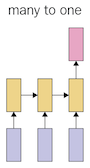

In the architecture above, each of the individual words from the sentence enter into individual box among the input boxes. However the structure of the sentence will be preserved, for example `this` enters the first box, `is` enters second box and `an` enters the third box.

The output box at the top will be the output that is `example`.

### 2. Interpreting RNN

You can think of RNN as a mechanism to hold memory—where the memory is contained within the hidden layer. It can be visualized as follows:

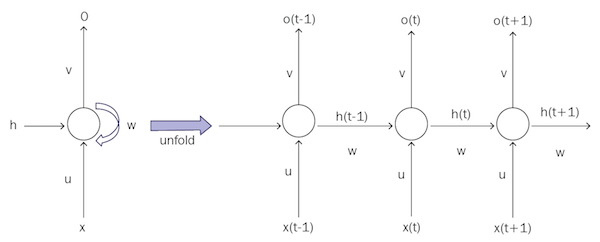

The network on the right is an unrolled version of the network on the left. The network on the right takes one input in each time step and extracts the output at each time step. However, if we are interested in the output in the fourth time step, we'll provide input in the previous three time steps and the output of the third time step is the predicted value for fourth time step.

#### 3. Building an RNN from scratch in Python

In [1]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.recurrent import SimpleRNN
from keras.layers.embeddings import Embedding
from keras.layers import LSTM
import numpy as np

Using TensorFlow backend.


In [2]:
from keras.utils import to_categorical

Let's consider an example text that looks as follows: `This is an example`.

The task at hand is to predict the third word given a sequence of two words.

| **Input**      | **Output**   | 
| :------------- | :----------: |
|  This is       | an           | 
|  is an         | example      |

**1.** Let's define the input and output in code, as follows:

In [3]:
#define documents
docs = ['this is','is an']
# define class labels
labels = ['an','example']

**2.** Let's preprocess our dataset so that it can be passed to an RNN:

In [4]:
from collections import Counter
counts = Counter()
for i,review in enumerate(docs+labels):
    counts.update(review.split())
words = sorted(counts, key=counts.get, reverse=True) 
vocab_size=len(words)
word_to_int = {word: i for i, word in enumerate(words, 1)}

In [5]:
print(word_to_int)

{'is': 1, 'an': 2, 'this': 3, 'example': 4}


In [6]:
words = sorted(counts, key=counts.get, reverse=True)
'''
from collections import Counter
x = Counter({'a':5, 'b':3, 'c':7})

Outside of counters, sorting can always be adjusted based on a key function;
.sort() and sorted() both take callable that lets you specify a value on which 
to sort the input sequence; sorted(x, key=x.get, reverse=True) would give you 
the same sorting as x.most_common(), but only return the keys, for example:

sorted(x, key=x.get, reverse=True)
['c', 'a', 'b']
'''

"\nfrom collections import Counter\nx = Counter({'a':5, 'b':3, 'c':7})\n\nOutside of counters, sorting can always be adjusted based on a key function;\n.sort() and sorted() both take callable that lets you specify a value on which \nto sort the input sequence; sorted(x, key=x.get, reverse=True) would give you \nthe same sorting as x.most_common(), but only return the keys, for example:\n\nsorted(x, key=x.get, reverse=True)\n['c', 'a', 'b']\n"

In [7]:
words = sorted(counts, key=counts.get, reverse=True)
print(words)

['is', 'an', 'this', 'example']


In [8]:
print((words, 1))
for i, word in enumerate(words,1):
      print((i,word))

(['is', 'an', 'this', 'example'], 1)
(1, 'is')
(2, 'an')
(3, 'this')
(4, 'example')


**3.** Modify the input and output words with their corresponding IDs, as follows:

In [9]:
encoded_docs = []
for doc in docs:
    encoded_docs.append([word_to_int[word] for word in doc.split()])
encoded_labels = []
for label in labels:
    encoded_labels.append([word_to_int[word] for word in label.split()])

In [10]:
print('encoded_docs: ',encoded_docs)
print('encoded_labels: ',encoded_labels)

encoded_docs:  [[3, 1], [1, 2]]
encoded_labels:  [[2], [4]]


**4.** One additional factor to take care of while encoding the input is the input length. In cases of sentiment analysis, the input text length can vary from one review to another. However, the neural network expects the input size to be fixed. To get around this problem, we perform padding on top of the input. Padding ensures that all inputs are encoded to have a similar length. While the lengths of both examples in our case is 2, in practice, we are very likely to face the scenario of differing lengths between input. In code, we perform padding as follows

In [11]:
# pad documents to a max length of 2 words
max_length = 2
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='pre')
print(padded_docs)

[[3 1]
 [1 2]]


**5.** The typical processing for outputs is to make them into dummy values, that is, make a one-hot-encoded version of the output labels, which is done as follows

In [14]:
# processing the output dataset
one_hot_encoded_labels = to_categorical(encoded_labels, num_classes=5) ####Why not have 2-5 classes
print(one_hot_encoded_labels)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]


**6.** An RNN expects the input to be `(batch_size, time_steps, and features_per_timestep)` in shape. Hence, we first reshape the padded_docs input into the following format:

In [15]:
padded_docs = padded_docs.reshape(2,2,1)

In [16]:
print(padded_docs[0][1])

[1]


**7.** Define the model—where we are specifying that we will initialize an RNN by using the SimpleRNN method

In [17]:
# define the model
embed_length=1
max_length=2
model = Sequential()
model.add(SimpleRNN(1,activation='tanh', return_sequences=False,recurrent_initializer='Zeros',
                    input_shape=(max_length,embed_length),unroll=True))

Typically, in a many-to-one task, where there are many inputs (one input in each time step) and outputs, `return_sequences` will be `false`, resulting in the output being obtained only in the final time step.

**8.** Connect the RNN output to five nodes of the output layer

In [18]:
model.add(Dense(5, activation='softmax'))

We have performed a `Dense(5)`, as there are five possible classes of output (the output of each example has 5 values, where each value corresponds to the probability of it belonging to word `ID 0` to word `ID 4`).

**9.** Compile and summarize the model:

In [19]:
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10        
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
None


**10.** Fit the model to predict the output from the input

In [21]:
model.fit(padded_docs.reshape(2,2,1),np.array(one_hot_encoded_labels),epochs=500, verbose=0)

**11.** Extract prediction on the first input data point

In [23]:
padded_docs[0]

array([[3],
       [1]], dtype=int32)

In [22]:
model.predict(padded_docs[0].reshape(1,2,1))

array([[0.01513512, 0.02723994, 0.46750897, 0.03055882, 0.45955703]],
      dtype=float32)

**12.** Building RNN from scratch

In [24]:
model.weights

[<tf.Variable 'simple_rnn_1/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.1041462]], dtype=float32)>,
 <tf.Variable 'simple_rnn_1/recurrent_kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.42572525]], dtype=float32)>,
 <tf.Variable 'simple_rnn_1/bias:0' shape=(1,) dtype=float32, numpy=array([-0.42550597], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(1, 5) dtype=float32, numpy=
 array([[ 0.9820599 ,  0.38863012, -1.2549587 ,  0.27253923, -1.2005792 ]],
       dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(5,) dtype=float32, numpy=
 array([-0.61160386, -0.61415964,  0.59387   , -0.6146539 ,  0.6308001 ],
       dtype=float32)>]

In [25]:
model.get_weights()

[array([[-2.1041462]], dtype=float32),
 array([[0.42572525]], dtype=float32),
 array([-0.42550597], dtype=float32),
 array([[ 0.9820599 ,  0.38863012, -1.2549587 ,  0.27253923, -1.2005792 ]],
       dtype=float32),
 array([-0.61160386, -0.61415964,  0.59387   , -0.6146539 ,  0.6308001 ],
       dtype=float32)]

In [29]:
model.get_weights()[0]

array([[-2.1041462]], dtype=float32)

In [30]:
model.predict(padded_docs[0].reshape(1,2,1))

array([[0.01513512, 0.02723994, 0.46750897, 0.03055882, 0.45955703]],
      dtype=float32)

In [31]:
padded_docs[0]

array([[3],
       [1]], dtype=int32)

In [32]:
input_t0 = 3
input_t0_kernel_bias = input_t0*model.get_weights()[0] + model.get_weights()[2]

In [33]:
hidden_layer0_value = np.tanh(input_t0_kernel_bias)

In [34]:
input_t1 = 1
input_t1_kernel_bias = input_t1*model.get_weights()[0] + model.get_weights()[2]

In [35]:
input_t1_recurrent = hidden_layer0_value*model.get_weights()[1]

In [36]:
total_input_t1 = input_t1_kernel_bias + input_t1_recurrent

In [37]:
output_t1 = np.tanh(total_input_t1)

In [38]:
final_output = output_t1*model.get_weights()[3] + model.get_weights()[4]
final_output

array([[-1.5883551, -1.000689 ,  1.8420448, -0.8857199,  1.8248894]],
      dtype=float32)

In [39]:
np.exp(final_output)/np.sum(np.exp(final_output))

array([[0.01513513, 0.02723995, 0.46750897, 0.03055884, 0.45955712]],
      dtype=float32)

$\frac{e^a}{(e^a+e^b+e^c)}$